<h1>Capstone Project - The Battle of Neighborhoods</h1>

<h3>Import all required libraries</h3>

In [1]:
!pip install bs4
!pip install pgeocode

from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

!pip install pgeocode
import pgeocode

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

     |████████████████████████████████| 122kB 11.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    attrs-20.3.0               |     pyhd3deb0d_0          41 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    entrypoints-0.3            |  pyhd8ed1ab_1003           8 KB  conda-forge
    folium-0.5.0    

<h3>Personal variables</h3>

In [2]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your FourSquare Access Token
VERSION = '20180604'

<h3>Functions to use later in this project</h3>

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

<h3>Data preparation</h3>

Toronto Neighbourhoods via Wikipedia

In [4]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969"
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib") 
tables = soup.find_all('table')
Toronto_data = pd.DataFrame(columns=["Postal Code", "Borough", "Neighborhood"])
for row in tables[0].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        if (col[1].text.strip() != 'Not assigned'):
            pcode = col[0].text.strip()
            bor = col[1].text.strip()
            neigh = col[2].text.strip()
            Toronto_data = Toronto_data.append({"Postal Code":pcode, "Borough":bor, "Neighborhood":neigh}, ignore_index=True)

Toronto_data.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Geographical Location data

In [5]:
nomi = pgeocode.Nominatim('CA')
T_data =  pd.DataFrame(columns=["Postal Code", "Borough", "Neighborhood","Latitude","Longitude"])
for ind in Toronto_data.index:
    pcode = Toronto_data['Postal Code'][ind]
    bor = Toronto_data['Borough'][ind]
    neigh = Toronto_data['Neighborhood'][ind]
    latt = nomi.query_postal_code(pcode).latitude
    long = nomi.query_postal_code(pcode).longitude
    
    T_data  = T_data.append({"Postal Code":pcode, "Borough":bor, "Neighborhood":neigh, "Latitude":latt, "Longitude":long}, ignore_index=True)
    

In [6]:
T_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


In [7]:
T_data.shape

(103, 5)

There are total of 103 different Neighborhoods in Toronto.

In [8]:
T_data = T_data.drop(labels=76, axis=0)

<h3>Data analysis</h3>

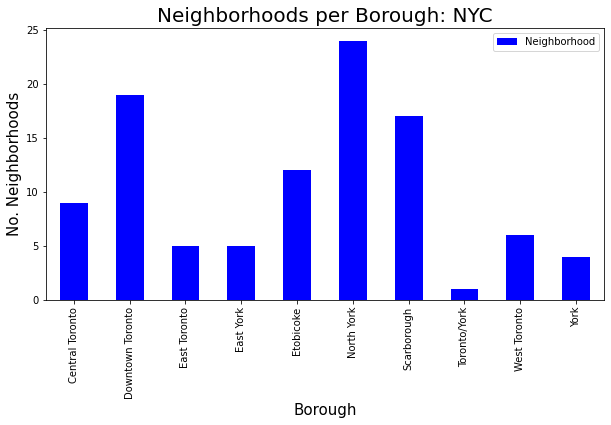

In [9]:
clr = "blue"
T_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()


In [10]:
# North York has most neighborhoods

# prepare neighborhood list that contains italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_tor=pd.DataFrame(columns=column_names)
count=1
for row in T_data.values.tolist():
    Posta_code, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(T_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    print(row)
    for resturant_detail in italian_restaurants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_tor = italian_rest_tor.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1



( 1 / 102 ) Italian Restaurants in Parkwoods, North York:0
['M3A', 'North York', 'Parkwoods', 43.7545, -79.33]
( 2 / 102 ) Italian Restaurants in Victoria Village, North York:0
['M4A', 'North York', 'Victoria Village', 43.7276, -79.3148]
( 3 / 102 ) Italian Restaurants in Regent Park, Harbourfront, Downtown Toronto:0
['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront', 43.6555, -79.3626]
( 4 / 102 ) Italian Restaurants in Lawrence Manor, Lawrence Heights, North York:0
['M6A', 'North York', 'Lawrence Manor, Lawrence Heights', 43.7223, -79.4504]
( 5 / 102 ) Italian Restaurants in Queen's Park, Ontario Provincial Government, Downtown Toronto:1
['M7A', 'Downtown Toronto', "Queen's Park, Ontario Provincial Government", 43.6641, -79.3889]
( 6 / 102 ) Italian Restaurants in Islington Avenue, Humber Valley Village, Etobicoke:0
['M9A', 'Etobicoke', 'Islington Avenue, Humber Valley Village', 43.6662, -79.5282]
( 7 / 102 ) Italian Restaurants in Malvern, Rouge, Scarborough:0
['M1B', 'Scarboro

In [11]:
italian_rest_tor.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,"Queen's Park, Ontario Provincial Government",5a69ba9112138476a91996f8,Dal Moro's Fresh Pasta To Go
1,Downtown Toronto,"Garden District, Ryerson",4d306dd82748b60c62b6dba0,Trattoria Mercatto
2,Downtown Toronto,St. James Town,4b49183ff964a520a46526e3,Terroni
3,Downtown Toronto,Central Bay Street,52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar
4,Downtown Toronto,"Richmond, Adelaide, King",4adc5c6af964a520da2b21e3,Mercatto


In [12]:
italian_rest_tor.shape

(25, 4)

We got 25 italian restaurants across the Toronto.

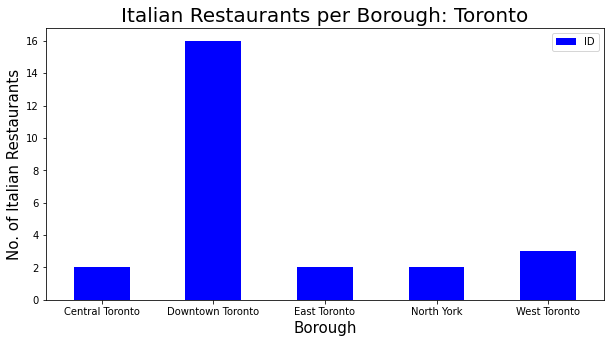

In [13]:
italian_rest_tor.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Borough: Toronto', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

We see that Downtown Toronto has the highest number of Italian restaurants. 

The ranking of each restaurant

In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_tor=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_tor.values.tolist():
    Borough, Neighborhood, ID, Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_tor),')','processed')
    italian_rest_stats_tor = italian_rest_stats_tor.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_tor.tail()

{'meta': {'code': 200, 'requestId': '6076d43b7831830180e4a1d7'}, 'response': {'venue': {'id': '5a69ba9112138476a91996f8', 'name': "Dal Moro's Fresh Pasta To Go", 'contact': {'phone': '6476756799', 'formattedPhone': '(647) 675-6799', 'instagram': 'dalmorostoronto', 'facebook': '141210776588312', 'facebookUsername': 'dalmorostoronto', 'facebookName': "Dal Moro's Fresh Pasta To Go - Toronto"}, 'location': {'address': '605 Yonge Street', 'crossStreet': 'Irwin Ave', 'lat': 43.66664070494267, 'lng': -79.38540023837237, 'labeledLatLngs': [{'label': 'display', 'lat': 43.66664070494267, 'lng': -79.38540023837237}], 'postalCode': 'M4Y 1Z5', 'cc': 'CA', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['605 Yonge Street (Irwin Ave)', 'Toronto ON M4Y 1Z5', 'Canada']}, 'canonicalUrl': 'https://foursquare.com/v/dal-moros-fresh-pasta-to-go/5a69ba9112138476a91996f8', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaur

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
20,Downtown Toronto,Stn A PO Boxes,54b9b9aa498e6f9349fd2125,Taverna Mercatto,73,7.9,17
21,Downtown Toronto,Stn A PO Boxes,4d75709afc766a31c3378e1a,Aria Ristorante,23,6.3,12
22,Downtown Toronto,"St. James Town, Cabbagetown",4e4e7aa06365e1419d021044,F'Amelia,30,8.6,17
23,Downtown Toronto,"First Canadian Place, Underground city",4adc5c6af964a520da2b21e3,Mercatto,46,7.2,26
24,Downtown Toronto,Church and Wellesley,5a69ba9112138476a91996f8,Dal Moro's Fresh Pasta To Go,10,7.7,8


In [15]:
italian_rest_stats_tor.shape

(25, 7)

The values like Likes, Tips are string values. Need to convert them into float

In [17]:
italian_rest_stats_tor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       25 non-null     object 
 1   Neighborhood  25 non-null     object 
 2   ID            25 non-null     object 
 3   Name          25 non-null     object 
 4   Likes         25 non-null     object 
 5   Rating        25 non-null     float64
 6   Tips          25 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.5+ KB


In [18]:
italian_rest_stats_tor['Likes'] = italian_rest_stats_tor['Likes'].astype('float64')
italian_rest_stats_tor['Rating'] = italian_rest_stats_tor['Rating'].astype('float64')
italian_rest_stats_tor['Tips'] = italian_rest_stats_tor['Tips'].astype('float64')
italian_rest_stats_tor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       25 non-null     object 
 1   Neighborhood  25 non-null     object 
 2   ID            25 non-null     object 
 3   Name          25 non-null     object 
 4   Likes         25 non-null     float64
 5   Rating        25 non-null     float64
 6   Tips          25 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.5+ KB


In [19]:
# Restaurant with maximum Likes
italian_rest_stats_tor.iloc[italian_rest_stats_tor['Likes'].idxmax()]

Borough                 Downtown Toronto
Neighborhood              St. James Town
ID              4b49183ff964a520a46526e3
Name                             Terroni
Likes                                279
Rating                                 8
Tips                                  95
Name: 2, dtype: object

In [20]:
# Restaurant with maximum Ratings
italian_rest_stats_tor.iloc[italian_rest_stats_tor['Rating'].idxmax()]

Borough                                          Downtown Toronto
Neighborhood    CN Tower, King and Spadina, Railway Lands, Har...
ID                                       52e88e92498e30016f1b3cf0
Name                                                     Bar Buca
Likes                                                         175
Rating                                                        8.9
Tips                                                           50
Name: 18, dtype: object

In [21]:
# Restaurant with maximum Tips
italian_rest_stats_tor.iloc[italian_rest_stats_tor['Tips'].idxmax()]

Borough                 Downtown Toronto
Neighborhood              St. James Town
ID              4b49183ff964a520a46526e3
Name                             Terroni
Likes                                279
Rating                                 8
Tips                                  95
Name: 2, dtype: object

Borough with the maximum average rating of italian restaurants

In [22]:
tor_borough_stats=italian_rest_stats_tor.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
tor_borough_stats.columns=['Borough','Average Rating']
tor_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
4,West Toronto,8.00000
2,East Toronto,7.65000
1,Downtown Toronto,7.58125
0,Central Toronto,7.20000
3,North York,6.60000


In [27]:
tor_neighborhood_stats=italian_rest_stats_tor.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
tor_neighborhood_stats.columns=['Neighborhood','Average Rating']
tor_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
2,"CN Tower, King and Spadina, Railway Lands, Har...",8.9
15,"St. James Town, Cabbagetown",8.6
17,"The Danforth West, Riverdale",8.2
1,"Brockton, Parkdale Village, Exhibition Place",8.2
10,"Parkdale, Roncesvalles",8.0
14,St. James Town,8.0
13,"Runnymede, Swansea",7.8
8,"Garden District, Ryerson",7.8
4,Church and Wellesley,7.7
11,"Queen's Park, Ontario Provincial Government",7.7


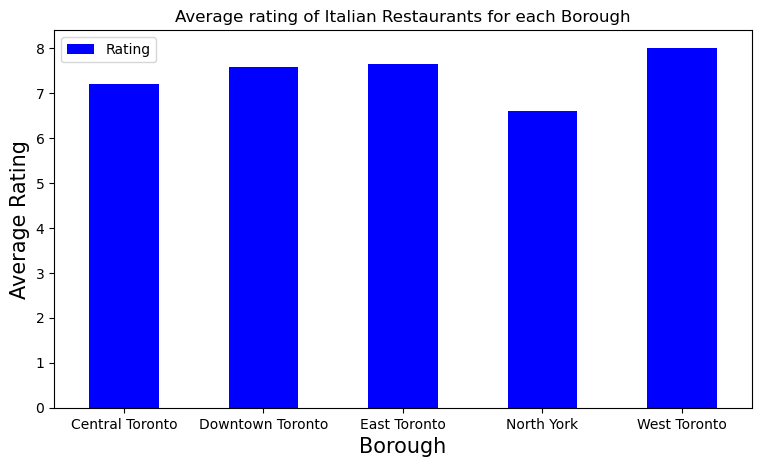

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Italian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize = 15)
italian_rest_stats_tor.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()



Join longitude and latitude for this data

In [32]:
tor_neighborhood_stats=pd.merge(tor_neighborhood_stats,T_data, on='Neighborhood')
tor_neighborhood_stats=tor_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
tor_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,North York,"Bedford Park, Lawrence Manor East",43.7335,-79.4177,6.600000
1,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.6383,-79.4301,8.200000
2,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.6404,-79.3995,8.900000
3,Downtown Toronto,Central Bay Street,43.6564,-79.3860,7.500000
4,Downtown Toronto,Church and Wellesley,43.6656,-79.3830,7.700000
5,Downtown Toronto,"Commerce Court, Victoria Hotel",43.6492,-79.3823,7.200000
6,Central Toronto,Davisville,43.7020,-79.3853,7.200000
7,Downtown Toronto,"First Canadian Place, Underground city",43.6492,-79.3823,7.200000
8,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,7.800000
9,East Toronto,"India Bazaar, The Beaches West",43.6693,-79.3155,7.100000


<h3>Show data on a map</h3>

In [33]:
# create map and display it

tor_neighborhood_stats['Label']=tor_neighborhood_stats['Borough']+'('+tor_neighborhood_stats['Average Rating'].map(str)+')'
tor_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in tor_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
for lat, lng, label in tor_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(tor_map)        
# add ratings to map
tor_map.add_child(rating)



In [64]:
tor_neighborhood_stats=italian_rest_stats_tor.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
tor_neighborhood_stats.columns=['Neighborhood','Average Rating']
tor_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,"CN Tower, King and Spadina, Railway Lands, Har...",8.9
15,"St. James Town, Cabbagetown",8.6
17,"The Danforth West, Riverdale",8.2
1,"Brockton, Parkdale Village, Exhibition Place",8.2
10,"Parkdale, Roncesvalles",8.0
14,St. James Town,8.0
13,"Runnymede, Swansea",7.8
8,"Garden District, Ryerson",7.8
4,Church and Wellesley,7.7
11,"Queen's Park, Ontario Provincial Government",7.7
